# 波士顿房价预测案例

在这个案例中，我们将利用波士顿郊区的房屋信息数据训练和测试一个模型，并对模型的性能和预测能力进行测试。

该数据集来自UCI机器学习知识库。波士顿房屋这些数据于1978年开始统计，共506个数据点，涵盖了麻省波士顿不同郊区房屋13种特征和房价的信息。

本项目将原始数据集存为csv格式，方便调用pandas做数据分析。

## 1、导入必要的工具包

In [1]:
import numpy as np  # 矩阵操作
import pandas as pd # SQL数据处理

from sklearn.metrics import r2_score  #评价回归预测模型的性能

import matplotlib.pyplot as plt   #画图
import seaborn as sns

# 图形出现在Notebook里而不是新窗口
%matplotlib inline

## 2、数据探索

### 2.1 读取数据

In [2]:
# path to where the data lies
dpath = './data/'
data = pd.read_csv(dpath +"boston_housing.csv")

#通过观察前5行，了解数据每列（特征）的概况
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15,396.90,4.98,24.0
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17,396.90,9.14,21.6
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17,392.83,4.03,34.7
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18,394.63,2.94,33.4
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18,396.90,5.33,36.2


###  2.2 数据基本信息
样本数目、特征维数
每个特征的类型、空值样本的数目、数据类型

In [3]:
data.shape

(506, 14)

In [4]:
## 各属性的统计信息（样本数目、均值、标准差、最小值、最大值、1/4分位数、中值（1/2分位数）、3/4分位数）
# 只计算数值型特征的统计信息（int、float）

data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.347826,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.083004,356.674032,12.653063,22.532806
std,8.601545,23.310593,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.280574,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.000000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.000000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.000000,391.440000,11.360000,21.200000
75%,3.677082,12.000000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.000000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### 2.3 数据探索
请见另一个文件：FE_BostonHousePrice.pynb

对数据的探索有助于我们在第三步中根据数据的特点选择合适的模型类型

### 2.4 数据准备

In [5]:
# 从原始数据中分离输入特征x和输出y
y = data['MEDV'].values
X = data.drop('MEDV', axis = 1)

当数据量比较大时，可用train_test_split从训练集中分出一部分做校验集；
样本数目较少时，建议用交叉验证
在线性回归中，留一交叉验证有简便计算方式，无需显式交叉验证

下面将训练数据分割成训练集和测试集，只是让大家对模型的训练误差、校验集上的测试误差估计、和测试集上的测试误差做个比较，实际任务中无需这么处理。

In [6]:
#将数据分割训练数据与测试数据
from sklearn.cross_validation import train_test_split

# 随机采样25%的数据构建测试样本，其余作为训练样本
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, test_size=0.2)

/Applications/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 2.5 数据预处理／特征工程

特征工程是实际任务中特别重要的环节。

scikit learn中提供的数据预处理功能：
http://scikit-learn.org/stable/modules/preprocessing.html
http://scikit-learn.org/stable/modules/classes.html#module- sklearn.feature_extraction

In [7]:
#发现各特征差异较大，需要进行数据标准化预处理
#标准化的目的在于避免原始特征值差异过大，导致训练得到的参数权重不归一，无法比较各特征的重要性

In [8]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

# 分别初始化对特征和目标值的标准化器
ss_X = StandardScaler()
ss_y = StandardScaler()

# 分别对训练和测试数据的特征以及目标值进行标准化处理
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)

#y_train = ss_y.fit_transform(y_train)
#y_test = ss_y.transform(y_test)

y_train = ss_y.fit_transform(y_train.reshape(-1, 1))
y_test = ss_y.transform(y_test.reshape(-1, 1))

## 3、确定模型类型

### 3.1 尝试缺省参数的线性回归

In [9]:
# 线性回归
#class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
from sklearn.linear_model import LinearRegression

# 使用默认配置初始化
lr = LinearRegression()

# 训练模型参数
lr.fit(X_train, y_train)

# 预测，下面计算score会自动调用predict
lr_y_predict = lr.predict(X_test)
lr_y_predict_train = lr.predict(X_train)

#显示特征的回归系数
lr.coef_

array([[-0.10643777,  0.13238196,  0.0252063 ,  0.08244512, -0.17705123,
         0.30530892, -0.00429841, -0.33726245,  0.2942942 , -0.24568977,
        -0.18931585,  0.08015874, -0.43340828]])

#### 3.1.1 模型评价

In [10]:
# 使用LinearRegression模型自带的评估模块（r2_score），并输出评估结果

#测试集
print 'The value of default measurement of LinearRegression on test is', lr.score(X_test, y_test)

#训练集
print 'The value of default measurement of LinearRegression on train is', lr.score(X_train, y_train)

The value of default measurement of LinearRegression on test is 0.69029595509
The value of default measurement of LinearRegression on train is 0.745144836731


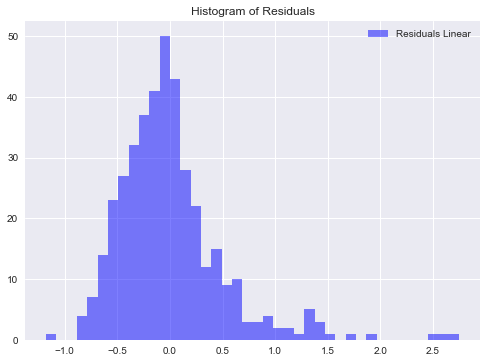

In [11]:
#在训练集上观察预测残差的分布，看是否符合模型假设：噪声为0均值的高斯噪声
f, ax = plt.subplots(figsize=(7, 5)) 
f.tight_layout() 
ax.hist(y_train - lr_y_predict_train,bins=40, label='Residuals Linear', color='b', alpha=.5); 
ax.set_title("Histogram of Residuals") 
ax.legend(loc='best');

残差分布和高斯分布比较匹配，但还是左skew，可能是由于数据集中有16个数据的y值为最大值，有噪声（预测残差超过2.5）

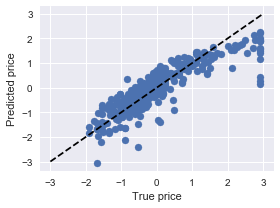

In [12]:
#还可以观察预测值与真值的散点图
plt.figure(figsize=(4, 3))
plt.scatter(y_train, lr_y_predict_train)
plt.plot([-3, 3], [-3, 3], '--k')   #数据已经标准化，3倍标准差即可
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price')
plt.tight_layout()

In [13]:
# 线性模型，随机梯度下降优化模型参数
# 随机梯度下降一般在大数据集上应用，其实本项目不适合用
from sklearn.linear_model import SGDRegressor

# 使用默认配置初始化线
sgdr = SGDRegressor(max_iter=1000)

# 训练：参数估计
sgdr.fit(X_train, y_train)

# 预测
#sgdr_y_predict = sgdr.predict(X_test)

sgdr.coef_

/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([-0.10574913,  0.13157943,  0.02653654,  0.08321306, -0.17634357,
        0.30438233, -0.00310495, -0.33847589,  0.29471804, -0.24409482,
       -0.18882621,  0.07977286, -0.43252972])

In [14]:
# 使用SGDRegressor模型自带的评估模块，并输出评估结果
print 'The value of default measurement of SGDRegressor on test is', sgdr.score(X_test, y_test)
print 'The value of default measurement of SGDRegressor on train is', sgdr.score(X_train, y_train)

The value of default measurement of SGDRegressor on test is 0.69037308284
The value of default measurement of SGDRegressor on train is 0.745084098607


In [15]:
#这里由于样本数不多，SGDRegressor可能不如LinearRegression。 sklearn建议样本数超过10万采用SGDRegressor

### 3.2 正则化的线性回归（L2正则 --> 岭回归）

In [16]:
#岭回归／L2正则
#class sklearn.linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0), fit_intercept=True, 
#                                  normalize=False, scoring=None, cv=None, gcv_mode=None, 
#                                  store_cv_values=False)
from sklearn.linear_model import  RidgeCV

alphas = [0.01, 0.1, 1, 10,20, 40, 80,100]
reg = RidgeCV(alphas=alphas, store_cv_values=True)   
reg.fit(X_train, y_train)       

RidgeCV(alphas=[0.01, 0.1, 1, 10, 20, 40, 80, 100], cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=True)

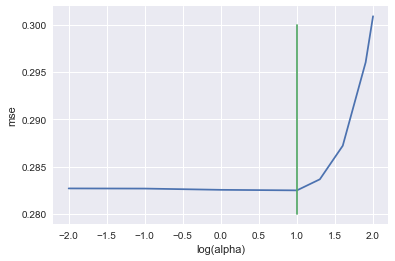

('alpha is:', 10.0)


array([[-0.09781781,  0.11357219, -0.00069185,  0.08574201, -0.14911378,
         0.31400952, -0.00946359, -0.30439602,  0.22375134, -0.17767457,
        -0.18290525,  0.07997069, -0.41743638]])

In [17]:
mse_mean = np.mean(reg.cv_values_, axis = 0)
plt.plot(np.log10(alphas), mse_mean.reshape(len(alphas),1)) 
plt.plot(np.log10(reg.alpha_)*np.ones(3), [0.28, 0.29, 0.30])
plt.xlabel('log(alpha)')
plt.ylabel('mse')
plt.show()

print ('alpha is:', reg.alpha_)
reg.coef_

In [18]:
# 使用LinearRegression模型自带的评估模块（r2_score），并输出评估结果
print 'The value of default measurement of RidgeRegression is', reg.score(X_test, y_test)

The value of default measurement of RidgeRegression is 0.696520650415


### 3.3 正则化的线性回归（L1正则 --> Lasso）

In [19]:
#### Lasso／L1正则
# class sklearn.linear_model.LassoCV(eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, 
#                                    normalize=False, precompute=’auto’, max_iter=1000, 
#                                    tol=0.0001, copy_X=True, cv=None, verbose=False, n_jobs=1,
#                                    positive=False, random_state=None, selection=’cyclic’)
from sklearn.linear_model import LassoCV

alphas = [0.01, 0.1, 1, 10,100]

lasso = LassoCV(alphas=alphas)   
lasso.fit(X_train, y_train)       

/Applications/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(alphas=[0.01, 0.1, 1, 10, 100], copy_X=True, cv=None, eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

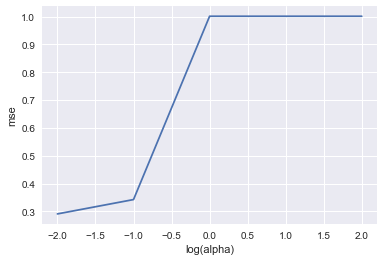

('alpha is:', 0.01)


array([-0.07849129,  0.09347763, -0.        ,  0.0807981 , -0.12532951,
        0.31939438, -0.        , -0.26700207,  0.15577565, -0.12534733,
       -0.17643178,  0.07117083, -0.43518032])

In [20]:
mses = np.mean(lasso.mse_path_, axis = 1)
plt.plot(np.log10(lasso.alphas_), mses) 
#plt.plot(np.log10(lasso.alphas_)*np.ones(3), [0.3, 0.4, 1.0])
plt.xlabel('log(alpha)')
plt.ylabel('mse')
plt.show()    
            
print ('alpha is:', lasso.alpha_)
lasso.coef_  

In [21]:
#在本任务中，最佳alpha为参数grid的最左端，最好再继续检查比当前更小的alpha是否会更好

In [22]:
# 使用LinearRegression模型自带的评估模块（r2_score），并输出评估结果
print 'The value of default measurement of Lasso Regression on test is', lasso.score(X_test, y_test)
print 'The value of default measurement of Lasso Regression on train is', lasso.score(X_train, y_train)

The value of default measurement of Lasso Regression on test is 0.691734666419
The value of default measurement of Lasso Regression on train is 0.740767149486
